# Demonstration of OVRO-LWA Stage 3 M&C

## Python APIs
1. ARX (Larry, Rick)
2. F-engine (Jack)
3. X-engine (Jack)
4. Data capture (Jayce)

## Setup

Set up scripts often run on lxdlwacr. lxdlwagpu03 is also ok.

Jack recommends:
1. Program and initialize SNAPs with `lwa_snap_feng_init.py -e -s -m -i -p -o ~/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml snap01`. Adding `-t` will send test data.
2. Fire up the GPU pipelines with `lwa352-start-pipeline.sh 0 1` on gpu01 and gpu02 (possibly killing existing pipelines first). One server can run up to 4 pipelines (192 channels x ~24 kHz each). All servers needed to run 32 pipelines with 73MHz bandwidth.
3. Watch X-engine log files until things are running with names `<hostname>.<pipeline_id>.log`
4. Trigger correlator output with `lwa352_arm_correlator.py`
5. Currently, success means 10s integrations sent to lxdlwagpu03 for capture by Jayce's bifrost pipeline. Good logging:

`2021-07-08 20:33:17 [INFO    ] CORR OUTPUT >> Sending complete for time_tag 318652171392122880 in 2.12 seconds (381714432 Bytes; 1.44 Gb/s)`

Note: 
* See also video recording of demo at https://youtu.be/H4ihj0EBHXE.


## Breakdown
1. lwa352-stop-pipeline.sh # essentially just a `killall lwa352-pipeline.py`

## Set up

In [1]:
%matplotlib inline

In [2]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Blues4
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd

output_notebook()

Loading BokehJS ...

In [3]:
cd ~/ovro_data_recorder/


/home/ubuntu/ovro_data_recorder


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from common import ETCD_HOST, ETCD_PORT  #  works in ovro_data_recorder directory

## etcd level M&C (low level)

In [5]:
import etcd3
le = etcd3.client(ETCD_HOST, ETCD_PORT)

# e.g., print a key:
# -- "le.get('/cmd/arx/2')"
# -- "le.get('/mon/snap/1')"

## ARX M&C

* Repo forthcoming "lwa-pyutils"
* This will be wrapped to refer to antenna, rather than ARX.
* Note that ARX come up with max attenuation (31.5)

In [6]:
from lwautils import lwa_arx
ma = lwa_arx.ARX()

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwautils/conf/etcdConfig.yml


In [7]:
adrs = [17,21,27,31]  # currently installed
for adr in adrs:
#    ma.load_cfg(adr, 1)  # optimal preset values
    ma.raw(adr, 'SETSC387')   # reasonable default
    
# setting custom config with dictionary
#ARX_CHAN_CFG = {}
#ARX_CHAN_CFG["dc_on"] = True
#ARX_CHAN_CFG["sig_on"] = True
#ARX_CHAN_CFG["narrow_lpf"] = False
#ARX_CHAN_CFG["narrow_hpf"] = False
#ARX_CHAN_CFG["first_atten"] = 7.5
#ARX_CHAN_CFG["second_atten"] = 15.0
#for adr in adrs:
#    ma.set_all_chan_cfg(adr, ARX_CHAN_CFG)  # this returns KeyError atm

In [8]:
for adr in adrs:
    print(ma.get_chan_cfg(adr, 0))

{'sig_on': True,
 'narrow_lpf': False,
 'narrow_hpf': False,
 'first_atten': 7.5,
 'second_atten': 15.0,
 'dc_on': True}

## F-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

In [10]:
from lwa_f import snap2_fengine
lwa_f = snap2_fengine.Snap2Fengine('snap01')

2021-08-19 16:59:18,945 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-08-19 16:59:19,302 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [11]:
print(list(sorted(lwa_f.blocks.keys()))

adc
autocorr
corr
delay
eq
eqtvg
eth
fpga
input
noise
packetizer
pfb
powermon
reorder
sync


In [12]:
lwa_f.eqtvg.tvg_is_enabled()
#lwa_f.eqtvg.tvg_disable()
#lwa_f.input.use_adc()

False

In [15]:
st0, st1 = lwa_f.input.get_status()
pows = np.array([v for (k,v) in st0.items() if 'pow' in k])
means = np.array([v for (k,v) in st0.items() if 'mean' in k])

In [16]:
TOOLTIPS = [("SNAP2 input", "$index")]
plot = figure(plot_width=950, plot_height=500, title='F stats', tools='hover,wheel_zoom,reset',
              tooltips=TOOLTIPS)
plot.xaxis.axis_label = 'Powers'
plot.yaxis.axis_label = 'Means'
_ = plot.scatter(x=pows, y=means)
show(plot)

2021-08-19 16:59:24,000 - lwa_f.blocks.block:snap01 - INFO - input - Getting histogram for stream 23


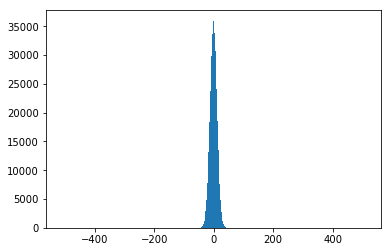

In [17]:
hist = lwa_f.input.plot_histogram(23)

In [18]:
specs = lwa_f.autocorr.get_new_spectra()   # before 4-bit scaling/quantization

In [43]:
len(specs), len(specs[0])

(16, 4096)

In [20]:
autospecs = []
for i in range(64):
    spec = lwa_f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
    autospecs.append(spec)

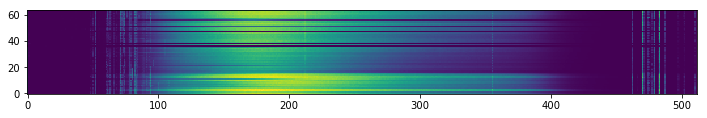

In [21]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
#for autospec in autospecs:
ax0.imshow(np.vstack(autospecs), origin='bottom')
#ax0.imshow(specs, origin='bottom')

In [24]:
np.shape(autospecs)

(64, 512)

In [51]:
from pyuvdata import UVData

In [72]:
uvd = UVData()

uvd.Nants_data = np.shape(autospecs)[0]
uvd.Nants_telescope = None
uvd.Nbls = uvd.Nblts = np.shape(autospecs)[0]
uvd.Nfreqs = np.shape(autospecs)[1]
uvd.Npols = 1  # What pol is represented?
uvd.Nspws = 1
uvd.Ntimes = 1
uvd.ant_1_array = uvd.ant_2_array = np.arange(uvd.Nblts)
uvd.antenna_names = uvd.antenna_numbers = np.arange(uvd.Nblts)  # Need to get actual antenna numbers
uvd.antenna_positions = None
uvd.baseline_array = 2048*(uvd.ant_1_array+1)+(uvd.ant_1_array+1)+2^16
uvd.channel_width = None
uvd.freq_array = None
uvd.instrument = uvd.telescope_name ='LWA'
uvd.integration_time = None
uvd.vis_units = 'uncalib'

In [74]:
uvd.read(filename=specs[0])#, file_type=None, multidim_index=False)


TypeError: expected str, bytes or os.PathLike object, not numpy.float32

In [46]:
#dd = {'x': list(range(512))}
#
#for i in range(64):
#    dd[str(i)] = autospecs[i]
#
#source = ColumnDataSource(dd)

In [47]:
TOOLTIPS = [
#    ("Frequency channel", "$index"),
#    ("Autocorrelation value", "$y"),
    ("SNAP2 autocorr", "$name"),
]

plot = figure(plot_width=950, plot_height=500, title='autocorr spectra', tooltips=TOOLTIPS, tools='hover,wheel_zoom,reset')
plot.xaxis.axis_label = 'Channel'
plot.yaxis.axis_label = 'Power'
for i in range(64):
    _ = plot.line(x=list(range(512)), y=autospecs[i], color='grey', name=str(i), hover_color='firebrick')
show(plot)

## X-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

"/mon/corr/xeng/<hostname>/pipeline/<pid>/corr" or "beamform"

In [100]:
from lwa352_pipeline_control import Lwa352PipelineControl
lwa_x = Lwa352PipelineControl(pipeline_id=0, etcdhost='10.42.0.64', host='lxdlwagpu01')

In [101]:
lwa_x.corr.get_bifrost_status()

{'pid': 2297,
 'name': 'Corr',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nchan 96 --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.34 --port 10000 --bufgbytes 4 --cores 1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4 --logfile /home/ubuntu/lxdlwagpu01.0.log ',
 'core': 4,
 'acquire': 0.0,
 'process': 0.0,
 'reserve': 0.0,
 'total': 0.0,
 'gbps': 0.0,
 'time': 1629246202.3362505,
 'stats': {'xgpu_acc_len': 480, 'state': 'starting'}}

In [ ]:
lwa_x.corr_acc.get_bifrost_status()

In [92]:
from astropy import time
time.Time.now().unix

1629246020.377641

## Data capture M&C

In [93]:
# gpu03 runs capture server
import mcs #  works in ovro_data_recorder directory
from common import LWATime #  works in ovro_data_recorder directory

from datetime import timedelta, datetime

c = mcs.Client()
mcs_id = 'drvs19'   # data recorder visibilities slow server 19 (end of x-engine IP address)

In [94]:
# start
t_now = LWATime(datetime.utcnow() + timedelta(seconds=15), format='datetime', scale='utc')
mjd_now = int(t_now.mjd)
mpm_now = int((t_now.mjd - mjd_now)*86400.0*1000.0)
r = c.send_command(mcs_id, 'start', start_mjd=mjd_now, start_mpm=mpm_now)

In [95]:
# stop
r = c.send_command(mcs_id, 'stop', stop_mjd='now', stop_mpm=0)

In [96]:
print(le.get(f'/mon/{mcs_id}/bifrost/rx_rate'), le.get(f'/mon/{mcs_id}/bifrost/max_process'))

(b'{"timestamp": 1628887492.0539849, "value": 37702901.297510155, "unit": "B/s"}', <etcd3.client.KVMetadata object at 0x7f0c3c36d400>) (b'{"timestamp": 1629246029.500292, "value": 0.0, "unit": "s"}', <etcd3.client.KVMetadata object at 0x7f0c3c392080>)


In [97]:
le.get(f'/mon/{mcs_id}/statistics/avg')

(b'{"timestamp": 1628887421.19215, "value": [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,